Enter the path to the CSV file:  /Users/apple/Documents/naarni/1.initial_analysis/data-2025-08-15_10_14.csv



Braking Events Analysis:
             start_time                end_time  start_speed_kmh  end_speed_kmh  duration_seconds  distance_covered_km  start_odometer_km  end_odometer_km
2025-08-14 05:11:51.475 2025-08-14 05:11:54.616        10.730469       0.042969             3.141                  NaN                NaN          193.875
2025-08-14 05:22:55.536 2025-08-14 05:22:59.155        13.566406       0.000000             3.619                  0.0            193.875          193.875
2025-08-14 05:23:44.815 2025-08-14 05:23:48.035         4.808594       0.000000             3.220                  0.0            193.875          193.875

Summary Statistics:
Total braking events: 3
Average braking time: 3.33 seconds
Average braking distance: 0.0000 km
Maximum braking time: 3.62 seconds
Maximum braking distance: 0.0000 km


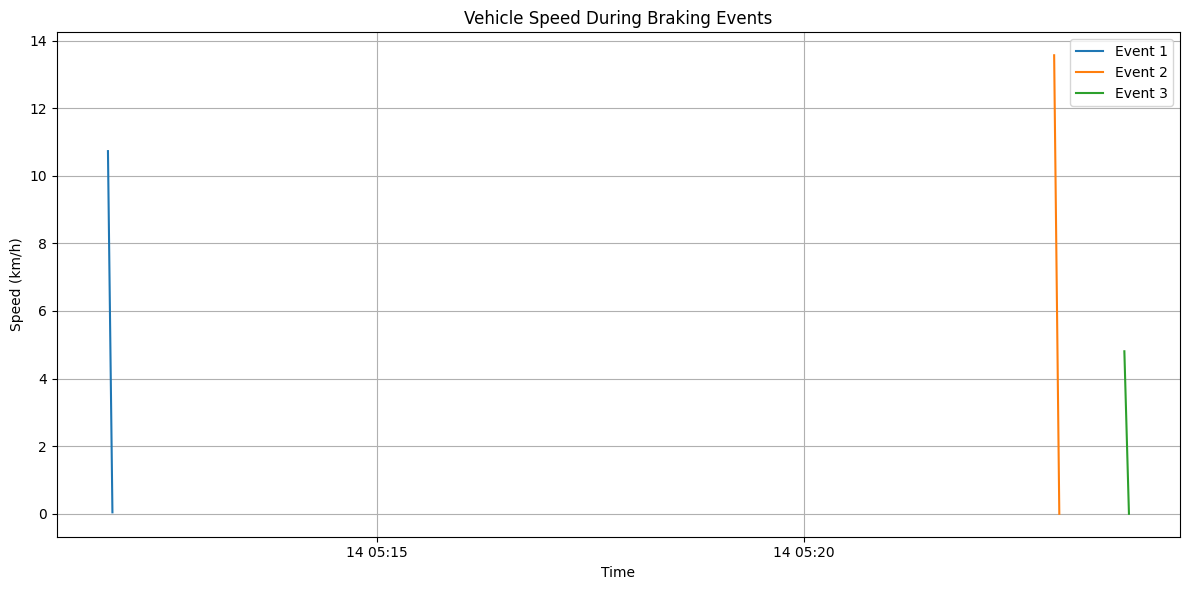


Results saved to braking_events_analysis.csv


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime



def analyze_braking_events(file_path):
    """
    Analyze EV bus CAN data to identify braking events where the vehicle comes to a complete stop.
    
    Parameters:
    file_path (str): Path to the CSV file containing CAN data
    
    Returns:
    DataFrame: DataFrame containing braking events with start/end times, distance, and duration
    """
    # file_path = "data-2025-08-01_17_05.csv"
    file_path = "/Users/apple/Documents/naarni/1.initial_analysis/data-2025-08-15_10_14.csv"
    # Read the CSV file
    try:
        # The data uses '|' as delimiter and has spaces around it
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
    # Drop the first column which appears to be an index
    df = df.drop(df.columns[0], axis=1)
    
    # Clean column names (remove leading/trailing spaces)
    df.columns = df.columns.str.strip()
    
    # Convert timestamp to datetime format (assuming it's in milliseconds)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Convert relevant columns to numeric, handling empty strings
    numeric_cols = [
        'BrakePedalPos', 'Brake_pedal', 'IgnitionStatus', 
        'Vehiclereadycondition', 'Gear_Position', 
        'OdoMeterReading', 'Vehicle_speed_VCU'
    ]
    
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Filter for when vehicle is ready to drive
    df_ready = df[
        (df['IgnitionStatus'] == 1) & 
        (df['Vehiclereadycondition'] == 1) &
        (df['Gear_Position'].isin([1, 2]))  # Drive or Reverse
    ].copy()
    
    # Sort by timestamp
    df_ready = df_ready.sort_values('timestamp').reset_index(drop=True)
    
    # Define thresholds
    BRAKE_THRESHOLD = 0  # Brake pedal position threshold
    SPEED_THRESHOLD_START = 1.0  # Minimum speed to consider as moving (km/h)
    SPEED_THRESHOLD_STOP = 0.1  # Speed below which vehicle is considered stopped (km/h)
    MAX_BRAKE_DURATION = 60  # Maximum braking duration to consider (seconds)
    
    # Initialize variables
    braking_events = []
    i = 0
    n = len(df_ready)
    
    while i < n:
        current_row = df_ready.iloc[i]
        
        # Check if brake is pressed and vehicle is moving
        if (current_row['BrakePedalPos'] > BRAKE_THRESHOLD and 
            current_row['Vehicle_speed_VCU'] > SPEED_THRESHOLD_START):
            
            start_time = current_row['timestamp']
            start_odo = current_row['OdoMeterReading']
            start_speed = current_row['Vehicle_speed_VCU']
            
            # Look ahead for vehicle stop
            j = i + 1
            stop_found = False
            
            while j < n:
                next_row = df_ready.iloc[j]
                time_diff = (next_row['timestamp'] - start_time).total_seconds()
                
                # Check if vehicle has stopped
                if next_row['Vehicle_speed_VCU'] <= SPEED_THRESHOLD_STOP:
                    end_time = next_row['timestamp']
                    end_odo = next_row['OdoMeterReading']
                    duration = (end_time - start_time).total_seconds()
                    distance = end_odo - start_odo
                    
                    # Only consider events with reasonable duration
                    if duration <= MAX_BRAKE_DURATION:
                        braking_events.append({
                            'start_time': start_time,
                            'end_time': end_time,
                            'start_speed_kmh': start_speed,
                            'end_speed_kmh': next_row['Vehicle_speed_VCU'],
                            'duration_seconds': duration,
                            'distance_covered_km': distance,
                            'start_odometer_km': start_odo,
                            'end_odometer_km': end_odo
                        })
                        stop_found = True
                        i = j  # Skip ahead to the end of this event
                    break
                
                # Stop looking if time exceeds maximum duration
                if time_diff > MAX_BRAKE_DURATION:
                    break
                
                j += 1
            
            if not stop_found:
                i += 1
        else:
            i += 1
    
    # Convert to DataFrame
    if braking_events:
        events_df = pd.DataFrame(braking_events)
        return events_df
    else:
        print("No braking events found that match the criteria.")
        return pd.DataFrame()

def plot_braking_events(events_df):
    """
    Plot braking events showing speed over time for each event.
    
    Parameters:
    events_df (DataFrame): DataFrame containing braking events
    """

    event_counter = 1
    if events_df.empty:
        print("No events to plot.")
        return
    
    plt.figure(figsize=(12, 6))
    
    for _, event in events_df.iterrows():
        # Create a time series for this event
        times = pd.date_range(
            start=event['start_time'], 
            end=event['end_time'], 
            periods=100
        )
        
        # Linear interpolation of speed from start to end
        speeds = np.linspace(
            event['start_speed_kmh'], 
            event['end_speed_kmh'], 
            100
        )
        
        plt.plot(times, speeds, label=f"Event {event_counter}")
        event_counter += 1  # Increment the counter for the next even
    
    plt.title('Vehicle Speed During Braking Events')
    plt.xlabel('Time')
    plt.ylabel('Speed (km/h)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    # Get file path from user
    file_path = input("Enter the path to the CSV file: ")
    
    # Analyze braking events
    events_df = analyze_braking_events(file_path)
    
    if not events_df.empty:
        # Display results
        print("\nBraking Events Analysis:")
        print(events_df.to_string(index=False))
        
        # Calculate summary statistics
        print("\nSummary Statistics:")
        print(f"Total braking events: {len(events_df)}")
        print(f"Average braking time: {events_df['duration_seconds'].mean():.2f} seconds")
        print(f"Average braking distance: {events_df['distance_covered_km'].mean():.4f} km")
        print(f"Maximum braking time: {events_df['duration_seconds'].max():.2f} seconds")
        print(f"Maximum braking distance: {events_df['distance_covered_km'].max():.4f} km")
        
        # Plot the events
        plot_braking_events(events_df)
        
        # Save results to CSV
        output_file = "braking_events_analysis.csv"
        events_df.to_csv(output_file, index=False)
        print(f"\nResults saved to {output_file}")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

def analyze_braking_events(file_path):
    """
    Analyze EV bus CAN data to identify braking events where the vehicle comes to a complete stop.
    
    Parameters:
    file_path (str): Path to the CSV file containing CAN data
    
    Returns:
    DataFrame: DataFrame containing braking events with start/end times, distance, and duration
    """
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None
    
    # Print file size for debugging
    file_size = os.path.getsize(file_path)
    print(f"File size: {file_size} bytes")
    
    # Try to read the CSV file with different delimiters
    delimiters = ['|', ',', ';', '\t']
    df = None
    
    for delimiter in delimiters:
        try:
            print(f"\nTrying with delimiter: '{delimiter}'")
            # Read first few lines to check
            with open(file_path, 'r') as f:
                first_lines = [next(f) for x in range(5)]
            print("First 5 lines of file:")
            for i, line in enumerate(first_lines):
                print(f"Line {i+1}: {line.strip()}")
            
            # Now try to read with pandas
            df = pd.read_csv(file_path, delimiter=delimiter, header=0, skipinitialspace=True)
            print(f"Successfully read CSV with delimiter '{delimiter}'")
            print(f"DataFrame shape: {df.shape}")
            print(f"Column names: {df.columns.tolist()}")
            break
        except Exception as e:
            print(f"Failed with delimiter '{delimiter}': {e}")
            continue
    
    if df is None:
        print("Error: Could not read CSV file with any common delimiter")
        return None
    
    # If we have only one column, it might be because the delimiter wasn't found
    if len(df.columns) == 1:
        print("Warning: Only one column detected. The delimiter might be incorrect.")
        print("Available data:")
        print(df.head())
        return None
    
    # Drop the first column which appears to be an index
    df = df.drop(df.columns[0], axis=1)
    
    # Clean column names (remove leading/trailing spaces)
    df.columns = df.columns.str.strip()
    
    # Print column names to debug
    print("\nAvailable column names after cleaning:")
    print(df.columns.tolist())
    
    # Check for timestamp column - it might have a different name
    timestamp_col = None
    for col in df.columns:
        if 'timestamp' in col.lower() or 'time' in col.lower():
            timestamp_col = col
            break
    
    if timestamp_col is None:
        print("Error: Could not find timestamp column. Available columns:")
        print(df.columns.tolist())
        return None
    
    print(f"Using '{timestamp_col}' as timestamp column")
    
    # Convert timestamp to datetime format and then to IST
    # First convert from epoch milliseconds to UTC datetime, then convert to IST
    try:
        df['timestamp'] = pd.to_datetime(df[timestamp_col], unit='ms') \
                                .dt.tz_localize('UTC') \
                                .dt.tz_convert('Asia/Kolkata')
    except Exception as e:
        print(f"Error converting timestamp: {e}")
        print("Trying alternative conversion...")
        try:
            # Try without timezone conversion first
            df['timestamp'] = pd.to_datetime(df[timestamp_col], unit='ms')
            print("Timestamp converted without timezone")
        except Exception as e2:
            print(f"Alternative conversion also failed: {e2}")
            return None
    
    # Check for required columns
    required_columns = ['BrakePedalPos', 'IgnitionStatus', 'Vehiclereadycondition', 
                       'Gear_Position', 'OdoMeterReading', 'Vehicle_speed_VCU']
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Error: Missing required columns: {missing_columns}")
        print("Available columns:")
        print(df.columns.tolist())
        return None
    
    # Print first few rows to check data structure
    print("\nData preview:")
    print(df.head())
    
    # Check BrakePedalPos values
    if 'BrakePedalPos' in df.columns:
        print("\nBrakePedalPos sample values:")
        print(df['BrakePedalPos'].head(10))
    
    # Keep all other columns as they are in the CSV (no conversion)
    
    # Filter for when vehicle is ready to drive
    # We need to be careful with comparisons since we're not converting to numeric
    # We'll convert to float only for comparison, keeping original data intact
    df_ready = df[
        (df['IgnitionStatus'] == '1') & 
        (df['Vehiclereadycondition'] == '1') &
        (df['Gear_Position'] == '2')  # Drive only
    ].copy()
    
    # Sort by timestamp
    df_ready = df_ready.sort_values('timestamp').reset_index(drop=True)
    
    # Define thresholds
    BRAKE_THRESHOLD = 0.0  # Brake pedal position threshold (as float)
    SPEED_THRESHOLD_START = 1.0  # Minimum speed to consider as moving (km/h)
    SPEED_THRESHOLD_STOP = 0.1  # Speed below which vehicle is considered stopped (km/h)
    MAX_BRAKE_DURATION = 60  # Maximum braking duration to consider (seconds)
    
    # Initialize variables
    braking_events = []
    i = 0
    n = len(df_ready)
    
    print(f"\nProcessing {n} records for braking events...")
    
    while i < n:
        current_row = df_ready.iloc[i]
        
        # Check if brake is pressed and vehicle is moving
        # Convert to float only for comparison, keeping original data intact
        try:
            brake_pos = float(current_row['BrakePedalPos'])
            speed = float(current_row['Vehicle_speed_VCU'])
        except (ValueError, TypeError):
            i += 1
            continue
        
        if brake_pos > BRAKE_THRESHOLD and speed > SPEED_THRESHOLD_START:
            start_time = current_row['timestamp']
            start_odo = current_row['OdoMeterReading']
            start_speed = current_row['Vehicle_speed_VCU']
            brake_position = current_row['BrakePedalPos']  # Keep original value
            
            # Look ahead for vehicle stop
            j = i + 1
            stop_found = False
            
            while j < n:
                next_row = df_ready.iloc[j]
                time_diff = (next_row['timestamp'] - start_time).total_seconds()
                
                # Check if vehicle has stopped
                try:
                    next_speed = float(next_row['Vehicle_speed_VCU'])
                except (ValueError, TypeError):
                    j += 1
                    continue
                
                if next_speed <= SPEED_THRESHOLD_STOP:
                    end_time = next_row['timestamp']
                    end_odo = next_row['OdoMeterReading']
                    duration = (end_time - start_time).total_seconds()
                    
                    # Convert odometer readings to numeric for distance calculation
                    try:
                        start_odo_num = float(start_odo)
                        end_odo_num = float(end_odo)
                        distance = end_odo_num - start_odo_num
                    except (ValueError, TypeError):
                        distance = 0.0
                    
                    # Only consider events with reasonable duration
                    if duration <= MAX_BRAKE_DURATION:
                        braking_events.append({
                            'start_time': start_time,
                            'end_time': end_time,
                            'start_speed_kmh': start_speed,
                            'end_speed_kmh': next_row['Vehicle_speed_VCU'],
                            'brake_position': brake_position,  # Original value
                            'duration_seconds': duration,
                            'distance_covered_km': distance,
                            'start_odometer_km': start_odo,  # Original value
                            'end_odometer_km': end_odo  # Original value
                        })
                        stop_found = True
                        i = j  # Skip ahead to the end of this event
                    break
                
                # Stop looking if time exceeds maximum duration
                if time_diff > MAX_BRAKE_DURATION:
                    break
                
                j += 1
            
            if not stop_found:
                i += 1
        else:
            i += 1
    
    # Convert to DataFrame
    if braking_events:
        events_df = pd.DataFrame(braking_events)
        return events_df
    else:
        print("No braking events found that match the criteria.")
        return pd.DataFrame()

def plot_braking_events(events_df):
    """
    Plot braking events showing speed over time for each event.
    
    Parameters:
    events_df (DataFrame): DataFrame containing braking events
    """
    if events_df.empty:
        print("No events to plot.")
        return
    
    plt.figure(figsize=(12, 6))
    
    for idx, event in events_df.iterrows():
        # Create a time series for this event
        times = pd.date_range(
            start=event['start_time'], 
            end=event['end_time'], 
            periods=100
        )
        
        # Convert speeds to numeric for plotting
        try:
            start_speed = float(event['start_speed_kmh'])
            end_speed = float(event['end_speed_kmh'])
            
            # Linear interpolation of speed from start to end
            speeds = np.linspace(start_speed, end_speed, 100)
            
            plt.plot(times, speeds, label=f"Event {idx+1}")
        except:
            print(f"Could not plot event {idx+1} due to non-numeric speed values")
    
    plt.title('Vehicle Speed During Braking Events (IST)')
    plt.xlabel('Time (IST)')
    plt.ylabel('Speed (km/h)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    # Get file path from user
    file_path = "data-2025-08-15_10_14.csv"
    
    print(f"Analyzing file: {file_path}")
    
    # Analyze braking events
    events_df = analyze_braking_events(file_path)
    
    # Check if events_df is None (error occurred) or empty (no events found)
    if events_df is None:
        print("\nAnalysis failed. Please check the error messages above.")
        return
    
    if events_df.empty:
        print("\nNo braking events found in the data.")
        return
    
    # Display detailed results for each braking event
    print("\nDetailed Braking Events Analysis:")
    print("="*120)
    print(f"{'Event':<6} {'Start Time (IST)':<20} {'End Time (IST)':<20} {'Odometer (km)':<15} {'Start Speed (km/h)':<18} {'Brake Position':<15} {'Time (sec)':<12} {'Distance (m)':<12}")
    print("-"*120)
    
    for idx, event in events_df.iterrows():
        try:
            distance_m = float(event['distance_covered_km']) * 1000
        except:
            distance_m = 0.0
            
        # Format timestamps for display
        start_time_str = event['start_time'].strftime('%Y-%m-%d %H:%M:%S')
        end_time_str = event['end_time'].strftime('%Y-%m-%d %H:%M:%S')
            
        print(f"{idx+1:<6} {start_time_str:<20} {end_time_str:<20} {event['start_odometer_km']:<15} {event['start_speed_kmh']:<18} "
              f"{event['brake_position']:<15} {event['duration_seconds']:<12.2f} {distance_m:<12.2f}")
    
    print("="*120)
    
    # Calculate summary statistics
    print("\nSummary Statistics:")
    print(f"Total braking events: {len(events_df)}")
    
    # Calculate averages by converting to numeric only when needed
    try:
        durations = [float(d) for d in events_df['duration_seconds']]
        print(f"Average braking time: {np.mean(durations):.2f} seconds")
        print(f"Maximum braking time: {np.max(durations):.2f} seconds")
    except:
        print("Could not calculate braking time statistics")
    
    try:
        distances = [float(d) * 1000 for d in events_df['distance_covered_km']]
        print(f"Average braking distance: {np.mean(distances):.2f} meters")
        print(f"Maximum braking distance: {np.max(distances):.2f} meters")
    except:
        print("Could not calculate braking distance statistics")
    
    try:
        brake_positions = [float(b) for b in events_df['brake_position']]
        print(f"Average brake pedal position: {np.mean(brake_positions):.2f}")
        print(f"Maximum brake pedal position: {np.max(brake_positions):.2f}")
    except:
        print("Could not calculate brake pedal position statistics")
    
    # Plot the events
    plot_braking_events(events_df)
    
    # Save results to CSV
    output_file = "braking_events_analysis.csv"
    events_df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")

if __name__ == "__main__":
    main()